In [1]:
import sys
import os
from time import time

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from skimage import measure
from scipy.optimize import linear_sum_assignment

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid', {'axes.grid': False})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline2_rgbspec_san19pairfreeze_actreggru_halluconvlstm.yaml'
weight = '../saved_models/san19freeze_halluconvlstm_actreggru/dim32_layer1_nsegment10/epoch_00049.model'
model_cfg_mod = {'num_segments': 10, 'hallu_model_cfg': 'exp_cfgs/haluconvlstm_32_1.yaml'}

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_flow(flow, num_segments, new_length):
    flow = flow.cpu().numpy()
    assert flow.shape[0] == 1
    _, _, h, w = flow.shape
    flow = flow.reshape([num_segments, new_length, 2, h, w])
    flow *= 1  # std
    flow += 128  # mean
    flow = flow.astype(np.uint8)
    flow_x = flow[:, :, 0, :, :]
    flow_y = flow[:, :, 1, :, :]
    return flow_x, flow_y


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

if model_cfg_mod is not None:
    model_params.update(model_cfg_mod)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model.load_model(weight)
model = model.to(device)
model.eval()

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [4]:
sample_id = 64

# Get a sample
for i, (sample, target) in enumerate(val_loader):
    sample = {k: v.to(device) for k, v in sample.items()}
    target = {k: v.to(device) for k, v in target.items()}

    if i == sample_id:
        break

# Forward
channel = 3
m = 'RGB'
num_segments = model.num_segments
sample_len = channel * model.new_length[m]
attn_layer = model.attention_layer
model = model.light_model

with torch.no_grad():
    base_out = model.rgb(sample[m].view((-1, sample_len) + sample[m].size()[-2:]))
    base_out = base_out.view(base_out.size(0), -1)

    attn = model.rgb.get_attention_weight(
        l_name=attn_layer[0],
        m_name=attn_layer[1],
        aggregated=True,
    )
    attn = attn.view([-1, num_segments] + list(attn.shape[1:]))

print(attn.shape)

torch.Size([1, 10, 32, 14, 14])


torch.Size([1, 30, 224, 224]) --> torch.Size([1, 10, 32, 14, 14])
torch.Size([1, 30, 112, 112]) --> torch.Size([1, 10, 32, 7, 7])
torch.Size([1, 30, 75, 75]) --> torch.Size([1, 10, 32, 4, 4])


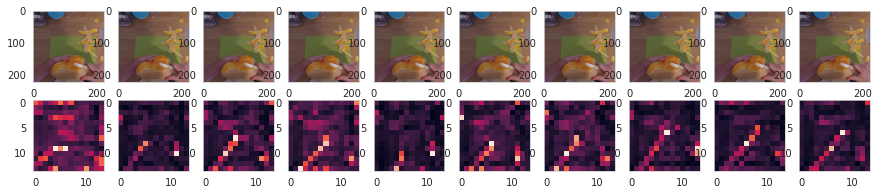

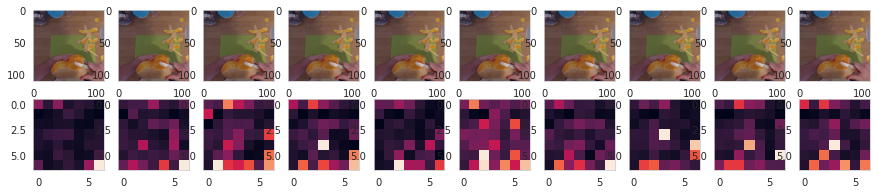

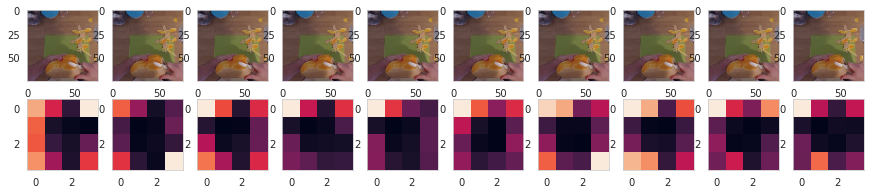

In [9]:
for i in range(3):
    step = 1+i
    rgb = deprocess_rgb(sample['RGB'], num_segments)[0][::step, ::step]
    x = sample['RGB'][:, :, ::step, ::step]
    
    with torch.no_grad():
        base_out = model.rgb(x.view((-1, sample_len) + x.size()[-2:]))
        base_out = base_out.view(base_out.size(0), -1)

        attn = model.rgb.get_attention_weight(
            l_name=attn_layer[0],
            m_name=attn_layer[1],
            aggregated=True,
        )
        attn = attn.view([-1, num_segments] + list(attn.shape[1:]))
    
    print('{} --> {}'.format(x.shape, attn.shape))

    fig, axes = plt.subplots(2, num_segments, figsize=(15, 3))
    for t in range(num_segments):
        axes[0, t].imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
        axes[1, t].imshow(attn[0, t].mean(dim=0).cpu().detach())